# Multi-Class Classification of ChestMNIST Dataset with CNN Models¶

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')


Mounted at /content/drive


The ChestMNIST dataset from the MedMNIST collection is a multi-label classification dataset derived from the NIH ChestX-ray14 dataset. It comprises 112,120 frontal-view chest X-ray images, each annotated with one or more of 14 disease labels.

1. Atelectasis
2. Cardiomegaly
3. Effusion
4. Infiltration
5. Mass
6. Nodule
7. Pneumonia
8. Pneumothorax
9. Consolidation
10. Edema
11. Emphysema
12. Fibrosis
13. Pleural Thickening
14. Hernia

## Import Libraries

In [21]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt





In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC


In [24]:
#data = np.load('/content/drive/MyDrive/mnist_medical_images/chestmnist.npz')
data = np.load('/data/chestmnist.npz')
print(data.files)  # shows stored arrays like ['images', 'labels']

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [25]:
# Extract arrays
x_train = data['train_images']
y_train = data['train_labels']
x_val   = data['val_images']
y_val   = data['val_labels']
x_test  = data['test_images']
y_test  = data['test_labels']

## Analyze Dataset

In [26]:
# check shapes
print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape, y_val.shape)
print("Test: ", x_test.shape, y_test.shape)

Train: (78468, 28, 28) (78468, 14)
Val:   (11219, 28, 28) (11219, 14)
Test:  (22433, 28, 28) (22433, 14)


In [27]:
disease_labels = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass",
    "Nodule", "Pneumonia", "Pneumothorax", "Consolidation", "Edema",
    "Emphysema", "Fibrosis", "Pleural Thickening", "Hernia"
]


In [28]:
label_counts = np.sum(np.concatenate([y_train, y_val, y_test]), axis=0)

for i, count in enumerate(label_counts):
    print(f"{disease_labels[i]}: {int(count)} samples")


Atelectasis: 11535 samples
Cardiomegaly: 2772 samples
Effusion: 13307 samples
Infiltration: 19870 samples
Mass: 5746 samples
Nodule: 6323 samples
Pneumonia: 1353 samples
Pneumothorax: 5298 samples
Consolidation: 4667 samples
Edema: 2303 samples
Emphysema: 2516 samples
Fibrosis: 1686 samples
Pleural Thickening: 3385 samples
Hernia: 227 samples


In [29]:
# Create a mapping for labels
label_map = {
    0: 'Atelectasis',
    1: 'Cardiomegaly',
    2: 'Effusion',
    3: 'Infiltration',
    4: 'Mass',
    5: 'Nodule',
    6: 'Pneumonia',
    7: 'Pneumothorax',
    8: 'Consolidation',
    9: 'Edema',
    10: 'Emphysema',
    11: 'Fibrosis',
    12: 'Pleural Thickening',
    13: 'Hernia'

}


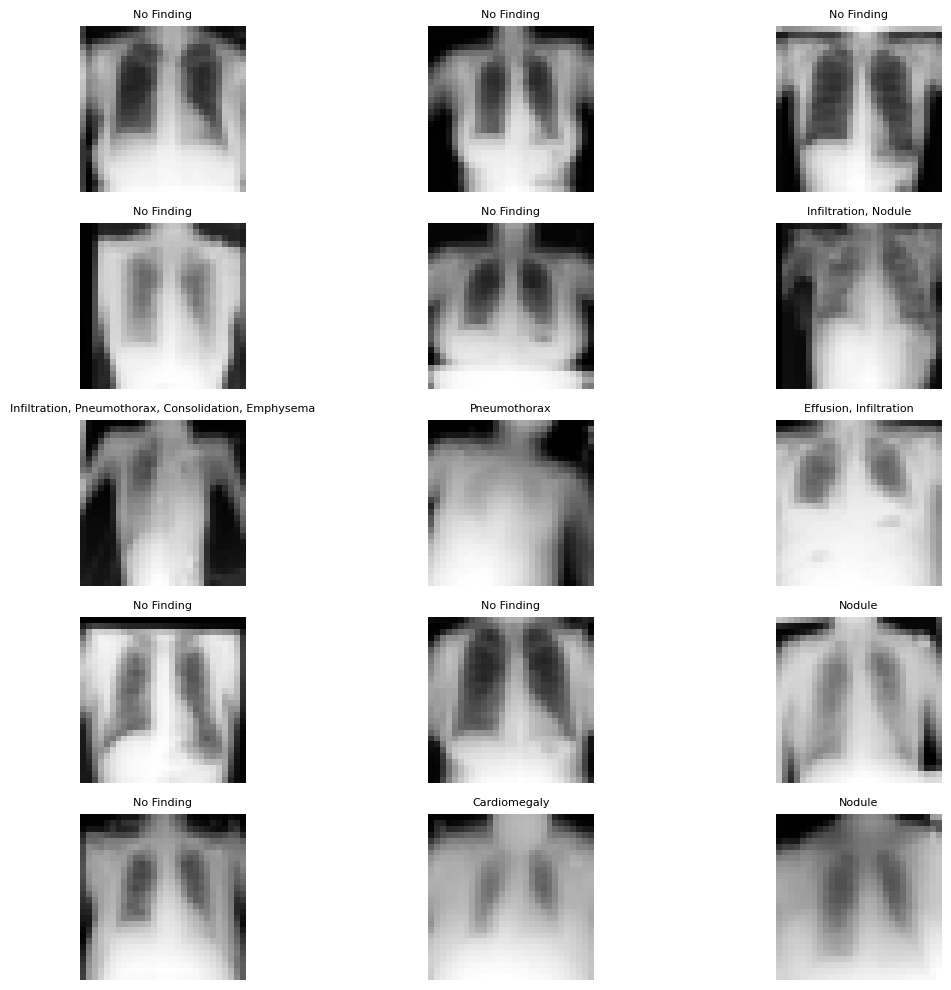

In [30]:
# Visualize a Grid of Sample Images per Label


# Number of images to show
num_images = 15
rows, cols = 5, 3

# Set up grid
fig, axes = plt.subplots(rows, cols, figsize=(12, 10))

# Plot each image with labels
for idx in range(num_images):
    ax = axes[idx // cols, idx % cols]
    img = x_train[idx]
    labels = y_train[idx]

    # Convert one-hot vector to label names using label_map
    label_names = [label_map[i] for i in range(len(labels)) if labels[i] == 1]
    title = ", ".join(label_names) if label_names else "No Finding" # when no disease labels marked

    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(title, fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [31]:
# Normalize data
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

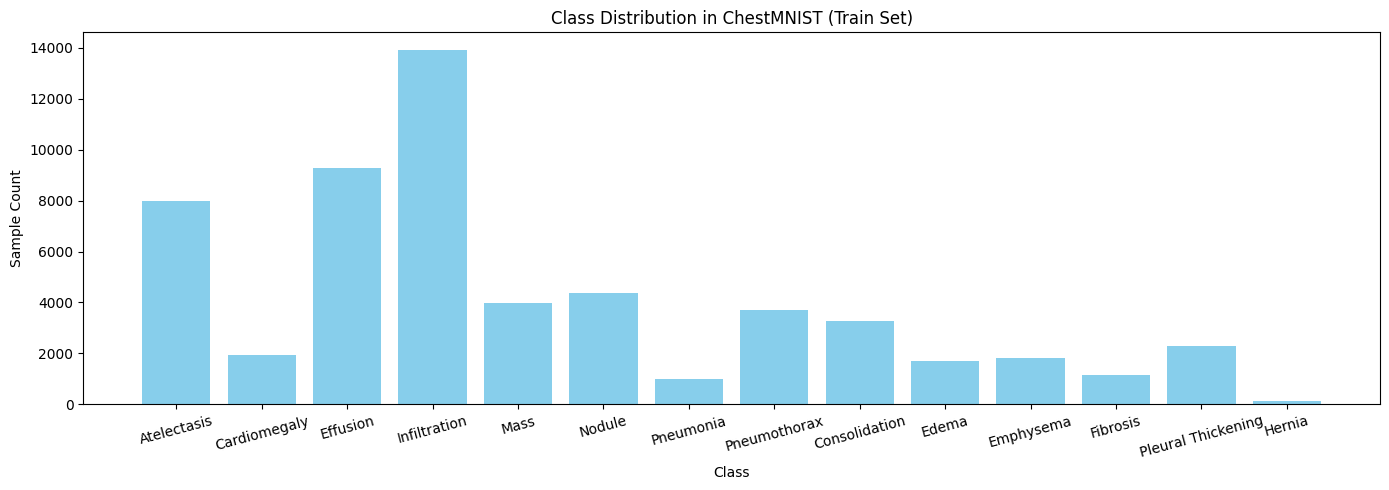

In [32]:
# Count occurrences of each class
class_names = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
               'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural Thickening', 'Hernia' ]

# Count how many times each class appears across all samples
counts = np.sum(y_train, axis=0)

# Plot bar chart
plt.figure(figsize=(14, 5))
plt.bar(class_names, counts, color='skyblue')
plt.title("Class Distribution in ChestMNIST (Train Set)")
plt.xlabel("Class")
plt.ylabel("Sample Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

**Class Distribution**

Uneven imbalanced class distribution.

Many samples have no condition at all (i.e., all 0)

A significant number of samples might be labeled with multiple conditions.

**Samples with No Condition vs Condition Present**

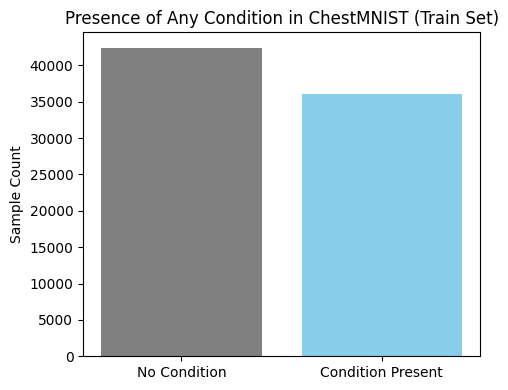

No of samples with condition present: 36063
No of samples with no condition: 42405


In [33]:


# y_train: shape (n_samples, 14), each row is a binary vector of labels
condition_present = np.sum(np.any(y_train == 1, axis=1))
no_condition = np.sum(np.all(y_train == 0, axis=1))

# Plot
plt.figure(figsize=(5, 4))
plt.bar(['No Condition', 'Condition Present'], [no_condition, condition_present], color=['gray', 'skyblue'])
plt.title("Presence of Any Condition in ChestMNIST (Train Set)")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

print(f'No of samples with condition present: {condition_present}')
print(f'No of samples with no condition: {no_condition}')

# **1. Simple CNN Model**

- Input: 28×28 grayscale images

- Output: 14 sigmoid-activated neurons

- Loss Function: binary_crossentropy (since  multi-label)

- Evaluation Metrics: AUC, F1-score, accuracy, etc.

In [34]:
# Input shape for ChestMNIST
input_shape = (28, 28, 1)
num_classes = 14

# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='sigmoid')  # Multi-label output
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
)

In [35]:
# Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,934 (882.55 KB)

 Trainable params: 225,742 (881.80 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:


# Create a directory to save model checkpoints
os.makedirs("/content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints", exist_ok=True)

# Define checkpoint path
checkpoint_path = "/content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras"

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]


## Training

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
2452/2453 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1733 - auc: 0.7091 - loss: 0.2113
Epoch 1: val_auc improved from -inf to 0.79585, saving model to /content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 116s 46ms/step - accuracy: 0.1733 - auc: 0.7091 - loss: 0.2113 - val_accuracy: 0.1289 - val_auc: 0.7958 - val_loss: 0.1712
Epoch 2/20
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1606 - auc: 0.7633 - loss: 0.1811
Epoch 2: val_auc did not improve from 0.79585
2453/2453 ━━━━━━━━━━━━━━━━━━━━ 141s 45ms/step - accuracy: 0.1606 - auc: 0.7633 - loss: 0.1811 - val_accuracy: 0.1365 - val_auc: 0.7864 - val_loss: 0.1727
Epoch 3/20
2451/2453 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1660 - auc: 0.7698 - loss: 0.1788
Epoch 3: val_auc improved from 0.79585 to 0.80336, saving model to /content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras
2453/2453 ━━━━━━━━━━━━━━

In [ ]:
results = model.evaluate(x_test,y_test)
print(f"Test Loss: {results[0]:.4f}, Test AUC: {results[1]:.4f}, Test Accuracy: {results[2]:.4f}")


702/702 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.1825 - auc: 0.8238 - loss: 0.1680
Test Loss: 0.1680, Test AUC: 0.8235, Test Accuracy: 0.1854


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Get prediction probabilities
y_pred_probs = model.predict(x_test)  # shape: (n_samples, 14)

#  Apply threshold to get binary predictions
y_pred = (y_pred_probs >= 0.3).astype(int)


print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
print("Micro AUC:", roc_auc_score(y_test, y_pred_probs, average='micro'))
print("Macro AUC:", roc_auc_score(y_test, y_pred_probs, average='macro'))


702/702 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step
                    precision    recall  f1-score   support

       Atelectasis       0.33      0.01      0.01      2420
      Cardiomegaly       0.64      0.02      0.03       582
          Effusion       0.48      0.24      0.32      2754
      Infiltration       0.38      0.17      0.24      3938
              Mass       0.25      0.00      0.00      1133
            Nodule       0.00      0.00      0.00      1335
         Pneumonia       0.00      0.00      0.00       242
      Pneumothorax       0.11      0.00      0.00      1089
     Consolidation       0.00      0.00      0.00       957
             Edema       0.00      0.00      0.00       413
         Emphysema       0.00      0.00      0.00       509
          Fibrosis       0.00      0.00      0.00       362
Pleural Thickening       0.00      0.00      0.00       734
            Hernia       0.00      0.00      0.00        42

         micro avg       0.42      0.08      0.14     1

The dataset is imbalanced, most samples have multiple labels, and some classes are rare. Hence low accuracy is expected in this multi-label setting

# **2. Simple CNN with class weights to address class imbalance**

In [36]:
#  Count Samples per Class


# Count positive samples per class
class_counts = np.sum(y_train, axis=0)

# Total number of samples
total_samples = y_train.shape[0]

# Calculate class weights (inverse frequency)
class_weights = total_samples / (len(class_counts) * class_counts)

# Normalize (optional)
class_weights = class_weights / np.max(class_weights)

print("Class weights:", class_weights)


Class weights: [0.018009   0.07384615 0.01554908 0.01034929 0.03610832 0.03291429
 0.14723926 0.0388664  0.04413117 0.0852071  0.08004447 0.12435233
 0.06318561 1.        ]


In [37]:
# Broadcast class_weights to each sample label
sample_weights_matrix = y_train * class_weights  # Only weights for positive labels
sample_weights = np.sum(sample_weights_matrix, axis=1)  # Collapse to (n_samples,)

## Define & Train Model

In [ ]:
# Weighted model

# Clone the existing model
model_weighted = tf.keras.models.clone_model(model)

# Compile the model
model_weighted.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
)

#training
history = model_weighted.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=20,
    sample_weight=sample_weights,
    callbacks=callbacks ,
)


Epoch 1/20
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 109s 86ms/step - accuracy: 0.1526 - auc: 0.6439 - loss: 0.0121 - val_accuracy: 0.1296 - val_auc: 0.7631 - val_loss: 0.2100 - learning_rate: 0.0010
Epoch 2/20
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 140s 84ms/step - accuracy: 0.1283 - auc: 0.7093 - loss: 0.0107 - val_accuracy: 0.1727 - val_auc: 0.7623 - val_loss: 0.2341 - learning_rate: 0.0010
Epoch 3/20
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 141s 83ms/step - accuracy: 0.1748 - auc: 0.7208 - loss: 0.0102 - val_accuracy: 0.3036 - val_auc: 0.7527 - val_loss: 0.2679 - learning_rate: 0.0010
Epoch 4/20
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 145s 86ms/step - accuracy: 0.1990 - auc: 0.7288 - loss: 0.0101 - val_accuracy: 0.2304 - val_auc: 0.7786 - val_loss: 0.2170 - learning_rate: 5.0000e-04
Epoch 5/20
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 140s 84ms/step - accuracy: 0.2037 - auc: 0.7364 - loss: 0.0101 - val_accuracy: 0.1481 - val_auc: 0.7746 - val_loss: 0.2101 - learning_rate: 5.0000e-04
Epoch 6/20
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 144s 

## Evaluation

In [ ]:
# Evaluate
results = model_weighted.evaluate(x_test, y_test)
print("Evaluation metrics weighted:", results)

702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.1225 - auc: 0.7616 - loss: 0.2135
Evaluation metrics weighted: [0.21364998817443848, 0.7607282400131226, 0.12530647218227386]


In [ ]:
y_pred_probs = model_weighted.predict(x_test) #Predict probabilities on test set. Returns softmax output for each class


y_pred = np.argmax(y_pred_probs, axis=1)  # Converts softmax probabilities into predicted class labels (integers).
y_true = y_test.flatten() # ensure that the test labels are in the correct 1D shape

702/702 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


In [ ]:
# Binarize predictions using threshold (e.g., 0.5)
y_pred = (y_pred_probs >= 0.3).astype(int)

#  Generate classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

Classification Report:

                    precision    recall  f1-score   support

       Atelectasis       0.20      0.00      0.00      2420
      Cardiomegaly       0.00      0.00      0.00       582
          Effusion       0.20      0.62      0.30      2754
      Infiltration       0.21      0.69      0.33      3938
              Mass       0.00      0.00      0.00      1133
            Nodule       0.00      0.00      0.00      1335
         Pneumonia       0.00      0.00      0.00       242
      Pneumothorax       0.00      0.00      0.00      1089
     Consolidation       0.00      0.00      0.00       957
             Edema       0.08      0.18      0.11       413
         Emphysema       0.00      0.00      0.00       509
          Fibrosis       0.00      0.00      0.00       362
Pleural Thickening       0.00      0.00      0.00       734
            Hernia       0.00      0.00      0.00        42

         micro avg       0.20      0.27      0.23     16510
         macro

In [ ]:

print("Micro AUC:", roc_auc_score(y_test, y_pred_probs, average='micro'))
print("Macro AUC:", roc_auc_score(y_test, y_pred_probs, average='macro'))

Micro AUC: 0.7607976933692926
Macro AUC: 0.6270779364260664


# **3. Simple CNN with Hyperparameter Optimization**

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args



# Define search space
search_space = [
    Real(1e-4, 1e-2, name='learning_rate'),
    Integer(32, 128, name='batch_size'),
    Real(0.2, 0.5, name='dropout_rate'),
]

@use_named_args(search_space)
def objective(learning_rate, batch_size, dropout_rate):
    tf.keras.backend.clear_session()  # clear session to avoid cluttered graph

    # Build model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(14, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.AUC(name='val_auc')]
    )

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=10,
        sample_weight=sample_weights,
        callbacks=callbacks,
        verbose=0
    )

    # Return negative val_auc (to maximize AUC)
    return -max(history.history['val_auc'])





In [ ]:
# Run Bayesian optimization
results = gp_minimize(objective, search_space, n_calls=15, random_state=42)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc improved from -inf to 0.68896, saving model to /content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras

Epoch 2: val_auc improved from 0.68896 to 0.74071, saving model to /content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras

Epoch 3: val_auc improved from 0.74071 to 0.74112, saving model to /content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras

Epoch 4: val_auc improved from 0.74112 to 0.74135, saving model to /content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras

Epoch 5: val_auc did not improve from 0.74135

Epoch 6: val_auc did not improve from 0.74135

Epoch 7: val_auc did not improve from 0.74135

Epoch 8: val_auc did not improve from 0.74135

Epoch 9: val_auc improved from 0.74135 to 0.74147, saving model to /content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras

Epoch 10: val_auc d

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc did not improve from 0.75279

Epoch 2: val_auc did not improve from 0.75279

Epoch 3: val_auc did not improve from 0.75279

Epoch 4: val_auc did not improve from 0.75279

Epoch 5: val_auc did not improve from 0.75279

Epoch 6: val_auc did not improve from 0.75279

Epoch 7: val_auc did not improve from 0.75279

Epoch 8: val_auc did not improve from 0.75279

Epoch 9: val_auc did not improve from 0.75279

Epoch 10: val_auc did not improve from 0.75279
Restoring model weights from the end of the best epoch: 10.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc did not improve from 0.75279

Epoch 2: val_auc did not improve from 0.75279

Epoch 3: val_auc did not improve from 0.75279

Epoch 4: val_auc did not improve from 0.75279

Epoch 5: val_auc did not improve from 0.75279

Epoch 6: val_auc did not improve from 0.75279

Epoch 7: val_auc did not improve from 0.75279

Epoch 8: val_auc did not improve from 0.75279

Epoch 9: val_auc did not improve from 0.75279

Epoch 10: val_auc did not improve from 0.75279
Restoring model weights from the end of the best epoch: 6.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc did not improve from 0.75279

Epoch 2: val_auc did not improve from 0.75279

Epoch 3: val_auc did not improve from 0.75279

Epoch 4: val_auc did not improve from 0.75279

Epoch 5: val_auc did not improve from 0.75279

Epoch 6: val_auc did not improve from 0.75279

Epoch 7: val_auc did not improve from 0.75279

Epoch 8: val_auc did not improve from 0.75279

Epoch 9: val_auc did not improve from 0.75279
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc did not improve from 0.75279

Epoch 2: val_auc did not improve from 0.75279

Epoch 3: val_auc did not improve from 0.75279

Epoch 4: val_auc did not improve from 0.75279

Epoch 5: val_auc did not improve from 0.75279

Epoch 6: val_auc did not improve from 0.75279

Epoch 7: val_auc improved from 0.75279 to 0.75377, saving model to /content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras

Epoch 8: val_auc improved from 0.75377 to 0.75606, saving model to /content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras

Epoch 9: val_auc did not improve from 0.75606

Epoch 10: val_auc improved from 0.75606 to 0.75840, saving model to /content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras
Restoring model weights from the end of the best epoch: 10.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_auc did not improve from 0.75840

Epoch 2: val_auc did not improve from 0.75840

Epoch 3: val_auc did not improve from 0.75840

Epoch 4: val_auc did not improve from 0.75840

Epoch 5: val_auc did not improve from 0.75840

Epoch 6: val_auc did not improve from 0.75840

Epoch 7: val_auc did not improve from 0.75840

Epoch 8: val_auc did not improve from 0.75840

Epoch 9: val_auc did not improve from 0.75840

Epoch 10: val_auc did not improve from 0.75840
Restoring model weights from the end of the best epoch: 10.


In [ ]:

print(" Best hyperparameters:")
for name, val in zip(['learning_rate', 'batch_size', 'dropout_rate'], results.x):
    print(f"  - {name}: {val}")


 Best hyperparameters:
  - learning_rate: 0.002430833687655261
  - batch_size: 124
  - dropout_rate: 0.27736418451454303


## Define & Train Model

In [ ]:
#  Retrain the best model using the best hyperparameters
best_lr = results.x[0]
best_bs = results.x[1]
best_do = results.x[2]

# Build the best model
best_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(best_do),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(best_do),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(best_do),
    Dense(14, activation='sigmoid')
])

# Compile the model
best_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=best_lr),
    metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
)

# Train the model
history = best_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=best_bs,
    sample_weight=sample_weights,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.1623 - auc: 0.6448 - loss: 0.0120
Epoch 1: val_auc improved from 0.75840 to 0.76303, saving model to /content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras
633/633 ━━━━━━━━━━━━━━━━━━━━ 117s 179ms/step - accuracy: 0.1623 - auc: 0.6449 - loss: 0.0120 - val_accuracy: 0.1284 - val_auc: 0.7630 - val_loss: 0.1879
Epoch 2/20
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.1685 - auc: 0.7129 - loss: 0.0105
Epoch 2: val_auc improved from 0.76303 to 0.77029, saving model to /content/drive/MyDrive/mnist_medical_images/custom_cnn1_chest_checkpoints/best_model.keras
633/633 ━━━━━━━━━━━━━━━━━━━━ 142s 180ms/step - accuracy: 0.1685 - auc: 0.7129 - loss: 0.0105 - val_accuracy: 0.1654 - val_auc: 0.7703 - val_loss: 0.2157
Epoch 3/20
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.1555 - auc: 0.7285 - loss: 0.0103
Epoch 3: val_auc did not improve from 0.77029
633/633 ━━━━━━━━━━━━━━━━━━

## Evaluation

In [ ]:
# Evaluate the final model on the test set
results = best_model.evaluate(x_test, y_test)
print(f" Test Loss: {results[0]:.4f}, AUC: {results[1]:.4f}, Accuracy: {results[2]:.4f}")


702/702 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.1502 - auc: 0.7829 - loss: 0.2217
 Test Loss: 0.2219, AUC: 0.7823, Accuracy: 0.1518


In [ ]:
y_pred_probs = best_model.predict(x_test) #Predict probabilities on test set. Returns softmax output for each class


y_pred = np.argmax(y_pred_probs, axis=1)  # Converts softmax probabilities into predicted class labels (integers).
y_true = y_test.flatten() # ensure that the test labels are in the correct 1D shape

702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step


In [ ]:
# Binarize predictions using threshold (e.g., 0.5)
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
y_pred = (y_pred_probs >= 0.3).astype(int)

#  Generate classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

Classification Report:

                    precision    recall  f1-score   support

       Atelectasis       0.25      0.20      0.22      2420
      Cardiomegaly       0.38      0.04      0.07       582
          Effusion       0.26      0.58      0.36      2754
      Infiltration       0.25      0.53      0.34      3938
              Mass       0.14      0.02      0.03      1133
            Nodule       0.06      0.00      0.00      1335
         Pneumonia       0.00      0.00      0.00       242
      Pneumothorax       0.17      0.04      0.07      1089
     Consolidation       0.09      0.01      0.01       957
             Edema       0.10      0.30      0.15       413
         Emphysema       0.00      0.00      0.00       509
          Fibrosis       0.00      0.00      0.00       362
Pleural Thickening       0.21      0.01      0.01       734
            Hernia       0.04      0.14      0.06        42

         micro avg       0.24      0.27      0.25     16510
         macro

In [ ]:

print("Micro AUC:", roc_auc_score(y_test, y_pred_probs, average='micro'))
print("Macro AUC:", roc_auc_score(y_test, y_pred_probs, average='macro'))

Micro AUC: 0.782438016646687
Macro AUC: 0.6843720022689819


# **4. Deeper CNN  with weighted Classes**

# Define & Train Model

In [38]:

model_dp = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    # Final layers
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(14, activation='sigmoid')  # 14 classes, multi-label
])


In [39]:
model_dp.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)


In [40]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

#training
history = model_dp.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=20,
    sample_weight=sample_weights,
    callbacks=callbacks ,
)


Epoch 1/20
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 606s 488ms/step - accuracy: 0.1655 - auc: 0.6766 - loss: 0.0111 - val_accuracy: 0.3922 - val_auc: 0.7688 - val_loss: 0.2153
Epoch 2/20
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 611s 479ms/step - accuracy: 0.1975 - auc: 0.7260 - loss: 0.0104 - val_accuracy: 0.1719 - val_auc: 0.7528 - val_loss: 0.2174
Epoch 3/20
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 623s 480ms/step - accuracy: 0.1757 - auc: 0.7375 - loss: 0.0100 - val_accuracy: 0.2535 - val_auc: 0.7788 - val_loss: 0.2202
Epoch 4/20
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 593s 483ms/step - accuracy: 0.1699 - auc: 0.7412 - loss: 0.0100 - val_accuracy: 0.1712 - val_auc: 0.7671 - val_loss: 0.2285
Epoch 5/20
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 638s 496ms/step - accuracy: 0.1800 - auc: 0.7478 - loss: 0.0100 - val_accuracy: 0.1761 - val_auc: 0.7781 - val_loss: 0.2184
Epoch 6/20
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 603s 481ms/step - accuracy: 0.1779 - auc: 0.7550 - loss: 0.0099 - val_accuracy: 0.1229 - val_auc: 0.7137 - val_loss: 0.2109
Epoc

# Evaluation

In [47]:
# Evaluate the final model on the test set
results =model_dp.evaluate(x_test, y_test)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}, Test AUC: {results[2]:.4f}")


702/702 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/step - accuracy: 0.2809 - auc: 0.7962 - loss: 0.2275
Test Loss: 0.2278, Test Accuracy: 0.2843, Test AUC: 0.7948


In [43]:
y_pred_probs = model_dp.predict(x_test) #Predict probabilities on test set. Returns softmax output for each class


y_pred = np.argmax(y_pred_probs, axis=1)  # Converts softmax probabilities into predicted class labels (integers).
y_true = y_test.flatten() # ensure that the test labels are in the correct 1D shape

702/702 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step


In [44]:
# Binarize predictions using threshold (e.g., 0.5)
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
y_pred = (y_pred_probs >= 0.3).astype(int)

#  Generate classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

Classification Report:

                    precision    recall  f1-score   support

       Atelectasis       0.20      0.57      0.29      2420
      Cardiomegaly       0.17      0.46      0.24       582
          Effusion       0.27      0.71      0.40      2754
      Infiltration       0.28      0.48      0.36      3938
              Mass       0.15      0.03      0.05      1133
            Nodule       0.00      0.00      0.00      1335
         Pneumonia       0.00      0.00      0.00       242
      Pneumothorax       0.13      0.17      0.15      1089
     Consolidation       0.14      0.26      0.18       957
             Edema       0.17      0.22      0.19       413
         Emphysema       0.07      0.06      0.06       509
          Fibrosis       0.00      0.00      0.00       362
Pleural Thickening       0.13      0.01      0.02       734
            Hernia       0.01      0.05      0.02        42

         micro avg       0.23      0.37      0.28     16510
         macro

In [45]:
print("Micro AUC:", roc_auc_score(y_test, y_pred_probs, average='micro'))
print("Macro AUC:", roc_auc_score(y_test, y_pred_probs, average='macro'))

Micro AUC: 0.7948788013684498
Macro AUC: 0.7023958594271805
